# Getting Started with RAiDER

**Author**: Jeremy Maurer, David Bekaert, Simran Sangha, Yang Lei - Jet Propulsion Laboratory, California Institute of Technology

This notebook provides an overview of how to get started using the RAiDER package for estimating tropospheric RADAR delays, and other functionality included in the **raiderDelay.py** program. We give an example of how to download and process delays using the ERA-5 weather model for the Los Angeles region. 

In this notebook, we will demonstrate how to:
- Use the raiderDelay.py command-line utility to download and process tropospheric delays
- Generate Zenith Delays over the Los Angeles region
- Generate Zenith Delays for a set of GNSS stations over the Los Angeles region

The notebook will take approximately 15 minutes to run all the way through aside from the data download step. 

<div class="alert alert-warning">
The initial setup (<b>Prep A</b> section) should be run at the start of the notebook. The overview sections do not need to be run in order. 
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format." Verify GDAL version >= 3.
- RAiDER needs to be installed to run this notebook
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: A single image acquired by a satellite at a particular time
- *AOI*: Area of interest: the lat/lon area (in RAiDER a square region) containing your query points
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *SLC*: Single-look complex image. A complex single-band raster that contains a single focused RADAR frame from a SAR satellite. For Sentinel-1, SLCs are Level-1 products. 
- *Weather model*: A reanalysis weather product defining temperature, pressure, and humidity on a regular grid in some coordinate system (e.g., at regular lat/lon intervals in the standard EPSG:4326 reference frame).
- *Delay*: The apparent displacement in an interferogram that occurs solely due to changes in weather conditions between two acquisitions.
    </div>
    

## Table of Contents

[**Overview of the raiderDelay.py program**](#overview)  
[1. Details of the user input options](#user-input)  
[- DateList](#date_arg)  
[- Time](#time_arg)  
[- Area of Interest](#aoi_arg)  
[- Line-of-sight information](#los_arg)   
[- Height information](#height_arg)  
[- Weather Model Type](#weather_model_arg)  
[- Other Runtime Parameters](#runtime_arg)
  
[**Example Calculations**](#examples)  
[1. Downloading the weather model data using a bounding box](#bounding_box_example)  
[2. Compute Zenith Delays using a bounding box](#bounding_box_ztd)  
[3. Compute Zenith Delays using a list of GNSS stations](#station_list_example)  
[4. Visualizing Zenith Delays for a list of GNSS stations](#station_list_visualization)  
[5. Compute Slant Delays using ISCE raster files](#raster_example)  

## Prep: Initial setup of the notebook

Please run the cell below prior to running the rest of the notebook to ensure RAiDER is installed and set your working directory. You can change the relevant directories as desired for your system.  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Defining the home and data directories
tutorial_home_dir = os.path.abspath(os.getcwd())
work_dir = os.path.abspath(os.getcwd())
print("Tutorial directory: ", tutorial_home_dir)
print("Work directory: ", work_dir)

# Verifying if RAiDER is installed correctly
try:
    import RAiDER
except:
    raise Exception('RAiDER is missing from your PYTHONPATH')

os.chdir(work_dir)

Tutorial directory:  /Users/jeremym/software/RAiDER-docs/notebooks/RAiDER_tutorial
Work directory:  /Users/jeremym/software/RAiDER-docs/notebooks/RAiDER_tutorial


## Overview of the raiderDelay.py program
<a id='overview'></a>

**`raiderDelay.py`** is a command-line program written in Python that allows for easy downloading and processing of tropospheric weather delays for InSAR correction or comparison with GNSS tropospheric delays.

We can explore the options by looking at the help menu for the program.

In [2]:
# Running raiderDelay.py -h will print the help menu
!raiderDelay.py -h

usage: raiderDelay.py [-h] --date DATELIST [DATELIST ...] --time TIME
                      (--latlon LAT LONG | --bbox S N W E | --station_file QUERY_AREA)
                      [--lineofsight LOS | --statevectors SV] [--dem DEM]
                      [--heightlvs HEIGHTLVS [HEIGHTLVS ...]]
                      [--model {ERA5,ERA5T,ERAI,MERRA2,WRF,HRRR,GMAO,HDF5,HRES,NCMR}]
                      [--files FILES [FILES ...]] [--weatherFiles WMLOC]
                      [--zref ZREF] [--parallel PARALLEL]
                      [--outformat OUTFORMAT] [--out OUT] [--download_only]
                      [--verbose]

Calculate tropospheric delay from a weather model.
Usage examples:
raiderDelay.py --date 20200103 --time 23:00:00 -b 39 40 -79 -78 --model ERA5 --zref 15000 -v
raiderDelay.py --date 20200103 --time 23:00:00 -b 39 40 -79 -78 --model ERA5 --zref 15000 --heightlvs 0 100 200 -v
raiderDelay.py --date 20200103 --time 23:00:00 --latlon test/scenario_1/geom/lat.dat test/scenario_1/geo

## Details of the user input options
<a id='user-input'></a>
RAiDER is quite flexible in terms of the input arguments it allows.  

### 1. Date or date list (**`--date DATE1 [DATE2 DATESTEP]`**)
<a id='date_arg'></a>

This argument is required unless pre-downloaded weather model files are directly specified. (see the [`--files`](#weather_model_arg) argument below).
The date(s) passed can be either: 
1) a single date, specified in psuedo-ISO 8601 format: 20180101, 2018-01-01, etc.  
2) a space-deliminated pair of dates, in which case all the dates between the pair listed will be downloaded and processed. E.g., '20180101 20190101'  
3) a space-delimited pair of dates plus an interval in days, to specify the date interval to download. E.g., '20180101 20190101 12'

### 2. Time of day (**`--time TIME`**)
<a id='time_arg'></a>

This argument is also required unless pre-downloaded weather model files are explicitly passed. Specify the time of day to download and process in psuedo-ISO 8601 format: 
1) T020000  
2) T02:00:00.000  
3) T0200  
4) 12:00:00  
5) 120000  
etc. 

### 3. Area of Interest (AOI) arguments
<a id='aoi_arg'></a>

RAiDER requires one of three different options as inputs for the AOI: 1) a bounding box, in which case the weather model grid nodes are used for x/y locations, 2) a station file, which should be a .csv containing at minimum the columns "Lat" and "Lon," and 3) ISCE-style latitude and longitude grid files in radar coordinates. Only one option should be used, and the arguments can be passed as described below.  

#### Bounding Box (**`--bbox S N W E`**)
- A list of four numbers describing a bounding box
- Format is South North West East
- Values can be integers or decimals. 
- A buffer will automatically be added to compensate for rays at the edge of the bounding box
- Example: ```--bbox 41 42 -78 -77```  

#### Latitude / Longitude files (**`--latlon LAT LONG`**)
- Format is ```--latlon <latitude file> <longitude file>```. 
- Files in gridded radar coordinates; i.e. 2-D files containing the latitude and longitude of each pixel
- Example: ```--latlon lat.rdr lon.rdr```  

#### Station file (**`--station_file STATION_FILE`**)
- A comma-delimited file with at least the columns "Lat" and "Lon"
- An example is a file containing a list of GNSS stations with location info
- If the heights of the stations are known, the height column should have the name "Hgt_m" and give ellipsoidal heights in meters. If heights are not known, RAiDER will download a DEM for the region encompassing the station locations to get the height info. 
- Example: ```--station_file stations.csv```

### 4. Line-of-sight Information
<a id='los_arg'></a>

This option is used to specify line-of-sight information. 
The line-of-sight is used to calculate the true rays from the ground pixel to the top of the troposphere, along of the line-of-sight to the sensor platform. One of the following two optional arguments may be specified; otherwise, RAiDER will compute the zenith delay (ZTD). 
In the future we will also incorporate the conventional slant delay calculation. 

#### RADAR Line-of-sight file in ISCE format (**`--lineofsight LOS`**)
- A two-band GDAL-readable raster file containing the look vector components for the sensor, of the same size as the radar/SLC images
- Band 1 should be incidence angle in degrees from vertical
- Band 2 should be heading in degrees clockwise from north
- Example: ```--lineofsight los.rdr```

#### State vector file (**`--statevectors SV`**)
- An ISCE-derived XML file, shelve file, text file, or ESA orbit file containing state vectors specifying the orbit of the sensor. 
- Example: ```--statevectors orbit.xml```

### 5. Height information
<a id='height_arg'></a>

Ellipsoidal heights are needed to compute absolute delays. These can come from a DEM or simply by specifying fixed height levels. By default, RAiDER will download a DEM. A user can also specify an existing DEM or a set of specified height levels. For the latter, RAiDER will produce a 3D cube of delays, where the xy information is specified by the AOI arguments and the z-levels are specified directly. 

#### DEM (**`--dem DEM`**)
- The DEM over the area of interest can be specified explicitly, or it will be downloaded on-the-fly. RAiDER will check the default location for a DEM (./geom), so if you download the DEM once it will not be downloaded again. 

#### Height levels (**`--heightlvs HEIGHTLVS`**)
- This option specifies a list of heights, for which the delay will be calculated. The result is a full 3-D cube of delays at the specified lat/lon grid and height levels. 

### 6. Weather Model Information
<a id='weather_model_arg'></a>

#### Weather model (**`--model {ERA5,ERA5T,ERAI,MERRA2,WRF,HRRR,GMAO,HDF5,HRES,NCMR}`**)
- Specifies the type of weather model to use
- Allowed models currently include ERA5, ERA5T, ERAI, MERRA2, HRRR, GMAO, HRES, and NCMR
- Must be included in the ALLOWED_MODELS list in allowed.py and have a reader module defined
- New weather models can be included following the template given in template.py

#### Files (**`--files FILES`**)
- A file containing the weather model data that can be processed using a defined reader
- An example usage is to re-process a file previously downloaded

#### Weather file directory (**`--weatherFiles WMLOC`**)
- Specifies the directory location of/to write weather model files
- Default is ./weather_files

### 7. Runtime parameters
<a id='runtime_arg'></a>

#### Reference integration height (**`--zref ZREF`**)
- Integration height to use when computing the total delay. 
- Default is 15 km. 

#### Parallel Computation flag (**`--parallel`**)
- Specifies the number of CPUs to use for parallel calculations
- Default is 1 (one) for serial processing

#### Output file format (**`--outformat OUTFORMAT`**)
- GDAL-compatible raster image format
- Default is ENVI
- For other types of inputs (bounding box, station list) this argument is not used

#### Output file directory (**`--out OUT`**)
- This specifies the location of the output files. 
- Default is the current directory

#### Download the weather model only (**`--download_only`**)
- Download the weather model only and do nothing else. 

#### Run in verbose mode (**`-v/--verbose`**)
- Runs the code in verbose mode. 

## Examples using RAiDER
<a id='runtime_arg'></a>

In this section we will demostrate some of the basic capabilities of RAiDER, using a region in southern California shown below. 
The study area is around Los Angles, chosen to be a a square box 10 x 10 deg centered on 34 deg latitude, -118 deg  longitude. (See the optical image below.)

![Optical Image at Los Angeles]()
<img src="img/optical.png" width="300" height="150">

### Downloading the weather model data using a bounding box
<a id='bounding_box_example'></a>

RAiDER uses weather model data from third parties to calculate weather model delays. We can use the --download_only option to download the data without doing any processing. For this excercise we will use the weather model available from the __[Global Model Assimilation Office](https://gmao.gsfc.nasa.gov/weather_prediction/)__ at NASA. 

You can also try the ERA-5 model from the __[European Medium-range Weather Forecast](https://www.ecmwf.int/)__ if you have access to ECMWF weather models, simply change "GMAO" to "ERA5".

In [3]:
# Try downloading the data 
!raiderDelay.py --date 20200103 --time 00:00:00 -b 29 39 -123 -113 --model GMAO --download_only -v

Weather model GMAO is available from 2014-02-20 00:00:00-Present


The weather model data is accessed through different APIs depending on the model. GMAO and MERRA-2 are both directly accessed using the OpenDAP interface, while ECMWF models have a custom API. RAiDER automatically uses the appropriate API for the weather model that you specify. Each model has a custom reader defined that is used to access the API and manipulate it to a consistent set of variables.

By default the weather model files are stored in a subfolder of the local directory called "weather_files." You can change this using the `--weatherFiles` option described above. 

In [4]:
# We can look at the downloaded file
!ls weather_files/

GMAO_2020_01_03_T00_00_00.nc


The downloaded weather model is a NETCDF file, so it can be viewed and manipulated using GDAL or any NETCDF utility or package. 

In [7]:
# GDAL provides an API to access the variables and attributes of the file
!gdalinfo weather_files/GMAO_2020_01_03_T00_00_00.nc

Driver: netCDF/Network Common Data Format
Files: weather_files/GMAO_2020_01_03_T00_00_00.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#datetime=2020_01_03T00_00_00
  NC_GLOBAL#date_created=2021_02_22T21_51_45
  NC_GLOBAL#title=GMAO weather model data
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":H
  SUBDATASET_1_DESC=[72x45x37] mid_layer_heights (32-bit floating-point)
  SUBDATASET_2_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":QV
  SUBDATASET_2_DESC=[72x45x37] specific_humidity (32-bit floating-point)
  SUBDATASET_3_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":PL
  SUBDATASET_3_DESC=[72x45x37] mid_level_pressure (32-bit floating-point)
  SUBDATASET_4_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":T
  SUBDATASET_4_DESC=[72x45x37] air_temperature (32-bit floating-point)
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  512.0)
Upper Right (  512.0,    0.0)
Lower Righ

Notice the file contains (usually) four variables, including height, pressure, temperature, and humidity. In some cases, pressure is not explicitly stored; instead the variables are provided at fixed pressure levels, or an intermediate variable like geopotential is provided. 

Notice that no information is printed about the projection or size of the variables. These variables can be queried using GDAL individually to show the projection and shape information. 

In [8]:
!cd weather_files
!gdalinfo NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00.nc":QV
!cd ..

Driver: netCDF/Network Common Data Format
Files: weather_files/GMAO_2020_01_03_T00_00_00.nc
Size is 37, 45
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-123.906250000000000,39.625000000000000)
Pixel Size = (0.312500000000000,-0.250000000000000)
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#datetime=2020_01_03T00_00_00
  NC_GLOBAL#date_created=2021_02_22T21_51_45
  NC_GLOBAL#title=GMAO weather model data
  NETCDF_DIM_EXTRA={z}
  NETCDF_DIM_z_DEF={72,5}
  NETCDF_

Once the weather model file has been downloaded, you can compute delays for the same area without re-downloading. RAiDER will check your input query points against the extents of the downloaded file and proceed with processing if the weather model file includes a large enough area. If not, then it will ask you to delete the existing file so that it can download a new one. 

In [9]:
# If we try to run the same datetime but a larger bounding box, we get a message asking us to delete the existing file
!raiderDelay.py --date 20200103 --time 00:00:00 -b 25 45 -123 -113 --model GMAO

Extent of the input lats/lons is: [25.0, 45.0, -123.0, -113.0]
Extent of the weather model is: [28.5, 39.5, -123.75, -112.5]
The weather model passed does not cover all of the input points; you need to download a larger area.


### Compute Zenith Delays for a bounding box
<a id='bounding_box_ztd'></a>

If you only specify a bounding box as your AOI, RAiDER will compute the Zenith delay at the locations of the native grid nodes of the weather model itself. Because our bounding box is the same as before, RAiDER will skip the download step and directly process the delays. 

RAiDER will warn you that it is using the existing weather model file, which is specific to a 1) date, 2) time, 3) model, and 4) AOI. 

In [10]:
# passing the original bounding 
!raiderDelay.py --date 20200103 --time 00:00:00 -b 29 39 -123 -113 --model GMAO

Once the delays have been processed, there are several files that get created. One is a set of plots that are for sanity checking the weather model data. These are .pdf files and show the weather model variables at two different heights and a profile at a central point. These plots are mainly used to ensure that custom weather models are getting processed correctly (see __[Defining Custom Weather Models](../Defining_Custom_Weather_Models/Defining_custom_Weather_Models_in_RAiDER.ipynb)__ for more details).

In [11]:
!ls *.pdf

GMAO_refractivity_hgt500_and_15000m.pdf GMAO_weather_hgt500_and_15000m.pdf


In addition, there are log files that get printed out. These can be especially helpful when troubleshooting or debugging. The "debug.log" file records all of the same information that gets printed to the console, while the "error.log" file records warnings and error messages, including tracebacks. These files are appended to instead of being overwritten, so the output of several calls to raiderDelay.py will be saved. 

In [15]:
!ls *.log

debug.log error.log


In [16]:
!head debug.log

[2021-02-22 21:51:35,650]            checkTime:254   INFO       Weather model GMAO is available from 2014-02-20 00:00:00-Present
[2021-02-22 21:51:45,650]  prepareWeatherModel:71    WARNING    download_only flag selected. No further processing will happen.
[2021-02-22 21:52:52,612]  prepareWeatherModel:55    WARNING    Weather model already exists, please remove it ("['./weather_files/GMAO_2020_01_03_T00_00_00.nc']") if you want to download a new one.
[2021-02-22 21:52:53,007]         _adjust_grid:345   INFO       Extent of the input lats/lons is: [25.0, 45.0, -123.0, -113.0]
[2021-02-22 21:52:53,008]         _adjust_grid:346   INFO       Extent of the weather model is: [28.5, 39.5, -123.75, -112.5]
[2021-02-22 21:52:53,008]         _adjust_grid:348   INFO       The weather model passed does not cover all of the input points; you need to download a larger area.
[2021-02-22 21:53:07,785]  prepareWeatherModel:55    WARNING    Weather model already exists, please remove it ("['./weather_f

In [17]:
!head error.log

[2021-02-22 21:51:45,650]  prepareWeatherModel:71    WARNING    download_only flag selected. No further processing will happen.
[2021-02-22 21:52:52,612]  prepareWeatherModel:55    WARNING    Weather model already exists, please remove it ("['./weather_files/GMAO_2020_01_03_T00_00_00.nc']") if you want to download a new one.
[2021-02-22 21:53:07,785]  prepareWeatherModel:55    WARNING    Weather model already exists, please remove it ("['./weather_files/GMAO_2020_01_03_T00_00_00.nc']") if you want to download a new one.


Notice that there are flags ("INFO", "WARNING", etc.) that alert you to the type of message that is being saved. 

Finally, we have the processed delay files. These are of two types: 
1) A NETCDF file containing a modified version of the weather model that has been processed and regularized   
2) Depending on the type of input query points, there may be a separate final delay file  

In [22]:
!ls -lt weather_files/

GMAO_2020_01_03_T00_00_00.nc
GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc


In the case of a bounding box input, there is no additional file written; the delays are stored in the processed weather model file. 

As before, we can use GDAL to examine the processed NETCDF file.

In [23]:
!gdalinfo weather_files/GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc

Driver: netCDF/Network Common Data Format
Files: weather_files/GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#datetime=2020_01_03T00_00_00
  NC_GLOBAL#date_created=2021_02_22T21_53_10
  NC_GLOBAL#title=Weather model data and delay calculations
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc":latitude
  SUBDATASET_1_DESC=[73x42x35] latitude (64-bit floating-point)
  SUBDATASET_2_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc":longitude
  SUBDATASET_2_DESC=[73x42x35] longitude (64-bit floating-point)
  SUBDATASET_3_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc":t
  SUBDATASET_3_DESC=[73x42x35] temperature (32-bit floating-point)
  SUBDATASET_4_NAME=NETCDF:"weather_files/GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc":p
  SUBDATASET_4_DESC=[73x42x35] pressure (32-bit floating-point)
  SUBDATASET_5_NAME=NETCDF:"we

Notice that there are several new variables in comparison with the original weather model data, including lats/lons and two new variables "wet" and "hydro;" these are the wet and hydrostatic refractivities (point-wise delays) that are calculated using the equation:

$$ N_{\text{hydro}} = k_1 \frac{P}{T} $$

$$ N_{\text{wet}} = k_2 \frac{e}{T} + k_3 \frac{e}{T^2} $$

These are integrated in the z-direction to produce the "wet_total" and "hydro_total" variables, which are the integrated (i.e. total) delays:

$$ \text{ZTD}_{\text{wet}} = 10^{-6} \int_{z = h}^{z_{ref}} N_{\text{wet}}(z) $$

$$ \text{ZTD}_{\text{hydro}} = 10^{-6} \int_{z = h}^{z_{ref}} N_{\text{hydro}}(z) $$

When passing a station list or raster files containing query points, RAiDER will generate separate files containing the wet and hydrostatic total delays in the main directory. 

Although not explicit in variable descriptions above, a further difference between the original and processed weather model data is that it is all in a uniform cube; i.e. the grid heights are the same across the entire area of interest. In contrast, the native weather models typically use some other fixed variable such as pressure levels. 

### Compute Zenith delays using a GNSS station list
<a id='station_list_example'></a>

When using a GNSS station list, the program by default will create a bounding box around the list of points. 
For demonstration purposes, we will use an example list of stations from
the L.A. area so that we don't have to download another weather model file. 

The station file **must be comma-delimited, and must contain at the minimum column names "Lat" and "Lon."** By default, RAiDER will download a DEM to get the height information for the list of stations; if the heights are specified in a column named "Hgt_m" RAiDER will use those and this will save some processing time. 

In [24]:
!raiderDelay.py --date 20200103 --time 00:00:00 --station_file data/sample_gnss_list.csv --model GMAO

Finished writing data to ['./GMAO_Delay_20200103T000000_Zmax15000.0.csv']


We can compare the files in weather_files to see what has been added: 

In [30]:
!ls -lt weather_files/

total 5312
-rw-r--r--  1 jeremym  staff  2090742 Feb 22 22:12 GMAO_2020_01_03_T00_00_00_29N_40N_125W_113W.nc
-rw-r--r--  1 jeremym  staff   614492 Feb 22 21:51 GMAO_2020_01_03_T00_00_00.nc


We now have a new file in the base directory, which has been copied from the original station list file and to which has been added some new variables.

In [32]:
!ls *.csv

GMAO_Delay_20200103T000000_Zmax15000.0.csv


In [33]:
!head GMAO_Delay_20200103T000000_Zmax15000.0.csv

ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
5PTS,36.429178603000004,-120.264976914,56.5231551,0.067772780891204,2.0252343290089683,2.093007109900172
7OAK,37.59498606,-114.75908955700001,1713.2781037999994,0.04629423450288038,1.678122532838138,1.7244167673410182
7ODM,34.116406899999994,-117.093191981,762.0717087,0.056575950936041584,1.8651668205113614,1.921742771447403
ACSB,33.274264933000005,-117.444891086,-12.2960356,0.07332437843809947,2.0297132880746167,2.103037666512716
ACSX,33.274265297,-117.44489206899999,-12.291230300000002,0.07332422488962133,2.0297122903449143,2.103036515234536
AERO,32.80746746,-117.12437979399999,92.6906227,0.06676666247363311,2.007724844423338,2.074491506896971
AGMT,34.594281855,-116.429377366,1337.8227700999996,0.04941655198114424,1.7523424504975753,1.8017590024787196
AIAH,33.849159884,-117.86247482200001,38.2203257,0.08493009923168751,2.020132422176894,2.105062521408582
AISD,33.023891888,-117.085783284,141.587007,0.07102242577585183,1.9973516893911119,

You can see that the new .csv file contains the original station data, but with the addition of the wet, hydrostatic, and total delays, all in meters. 

### Visualizing Zenith delays for a list of GNSS stations
<a id='station_list_visualization'></a>

Once we have the delays in the .csv file, we can use Pandas to view and manipulate the data

In [35]:
delays = pd.read_csv('GMAO_Delay_20200103T000000_Zmax15000.0.csv')

In [36]:
delays.head()

,ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
0,5PTS,36.429179,-120.264977,56.523155,0.067773,2.025234,2.093007
1,7OAK,37.594986,-114.759090,1713.278104,0.046294,1.678123,1.724417
2,7ODM,34.116407,-117.093192,762.071709,0.056576,1.865167,1.921743
3,ACSB,33.274265,-117.444891,-12.296036,0.073324,2.029713,2.103038
4,ACSX,33.274265,-117.444892,-12.291230,0.073324,2.029712,2.103037


<AxesSubplot:xlabel='Hgt_m', ylabel='totalDelay'>

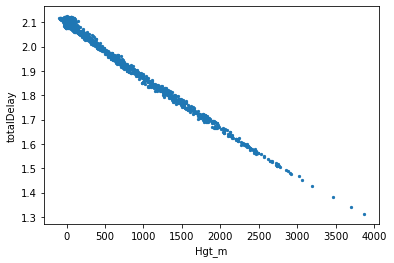

In [37]:
delays.plot.scatter(x='Hgt_m',y='totalDelay', marker='.')

We can also plot the total (absolute) delays in space. 

<AxesSubplot:xlabel='Lon', ylabel='Lat'>

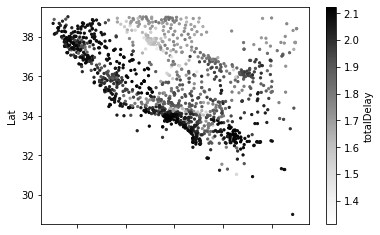

In [39]:
delays.plot.scatter(x='Lon',y='Lat', marker='.', c='totalDelay')

### Compute Slant Delays with ISCE raster files
<a id='raster_example'></a>

In [ ]:
# To be completed